In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import fashion_mnist, plot_graphs
import numpy as np

In [17]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

In [23]:
class Net(nn.Module):
    def __init__(self, overfit=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        
        self.overfit = overfit
        if overfit:
            self.fc2_2 = nn.Linear(128, 128)
        
        self.fc3 = nn.Linear(128, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        if self.overfit:
            x = torch.tanh(self.fc2_2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [83]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    correct = {k: 0. for k in models}
        
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)

            pred = output.data.max(1, keepdim=True)[1]
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
        
        correct_pct = {k: 100. * correct[k] / train_size for k in correct}
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss.item(), correct_pct[k]))

In [89]:
models = {'default': Net(False)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [90]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [91]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.332335
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.758691
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.500336
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.622856
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.364988
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.623485
Test set:
default: Loss: 0.4795	Accuracy: 8331.0/10000 (83%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.353437
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.448117
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.293409
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.342475
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.436652
Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.358994
Test set:
default: Loss: 0.4127	Accuracy: 8522.0/10000 (85%)

Train Epoch: 3 [0/50000 (0%)]	Losses default: 0.236317
Train Epoch: 3 [10000/50000 (20%)]	Losses default: 0.604874
Train Epoch: 3 [20000/50000 (40%)]	Losses default

Train Epoch: 20 [40000/50000 (80%)]	Losses default: 0.172151
Train Epoch: 20 [50000/50000 (100%)]	Losses default: 0.114929
Test set:
default: Loss: 0.2994	Accuracy: 8887.0/10000 (89%)

Train Epoch: 21 [0/50000 (0%)]	Losses default: 0.112590
Train Epoch: 21 [10000/50000 (20%)]	Losses default: 0.101352
Train Epoch: 21 [20000/50000 (40%)]	Losses default: 0.176670
Train Epoch: 21 [30000/50000 (60%)]	Losses default: 0.252738
Train Epoch: 21 [40000/50000 (80%)]	Losses default: 0.194424
Train Epoch: 21 [50000/50000 (100%)]	Losses default: 0.205028
Test set:
default: Loss: 0.3034	Accuracy: 8882.0/10000 (89%)

Train Epoch: 22 [0/50000 (0%)]	Losses default: 0.062770
Train Epoch: 22 [10000/50000 (20%)]	Losses default: 0.257508
Train Epoch: 22 [20000/50000 (40%)]	Losses default: 0.270291
Train Epoch: 22 [30000/50000 (60%)]	Losses default: 0.131127
Train Epoch: 22 [40000/50000 (80%)]	Losses default: 0.135157
Train Epoch: 22 [50000/50000 (100%)]	Losses default: 0.101000
Test set:
default: Loss: 0.30

Train Epoch: 40 [10000/50000 (20%)]	Losses default: 0.045018
Train Epoch: 40 [20000/50000 (40%)]	Losses default: 0.066134
Train Epoch: 40 [30000/50000 (60%)]	Losses default: 0.146522
Train Epoch: 40 [40000/50000 (80%)]	Losses default: 0.056049
Train Epoch: 40 [50000/50000 (100%)]	Losses default: 0.114233
Test set:
default: Loss: 0.3809	Accuracy: 8732.0/10000 (87%)

Train Epoch: 41 [0/50000 (0%)]	Losses default: 0.130120
Train Epoch: 41 [10000/50000 (20%)]	Losses default: 0.101247
Train Epoch: 41 [20000/50000 (40%)]	Losses default: 0.220591
Train Epoch: 41 [30000/50000 (60%)]	Losses default: 0.090572
Train Epoch: 41 [40000/50000 (80%)]	Losses default: 0.096370
Train Epoch: 41 [50000/50000 (100%)]	Losses default: 0.149048
Test set:
default: Loss: 0.3460	Accuracy: 8868.0/10000 (89%)

Train Epoch: 42 [0/50000 (0%)]	Losses default: 0.170337
Train Epoch: 42 [10000/50000 (20%)]	Losses default: 0.088597
Train Epoch: 42 [20000/50000 (40%)]	Losses default: 0.033924
Train Epoch: 42 [30000/50000 (

In [92]:
for k in train_log:
    test_log['train_' + k] = train_log[k]

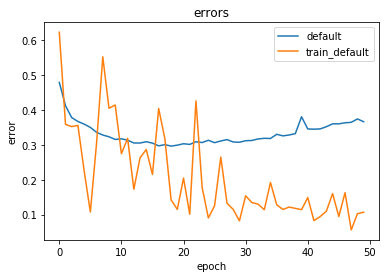

In [93]:
plot_graphs(test_log, 'loss')

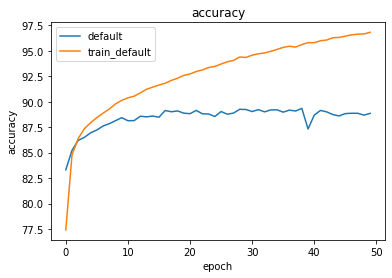

In [94]:
plot_graphs(test_log, 'accuracy')

In [95]:
test_log

{'default': [(0.4794587513923645, 83.31),
  (0.41265433950424196, 85.22),
  (0.378459229850769, 86.2),
  (0.36731080493927004, 86.5),
  (0.3597502716064453, 86.94),
  (0.35032729592323303, 87.22),
  (0.33629590969085693, 87.61),
  (0.32841589736938476, 87.84),
  (0.32345869493484497, 88.13),
  (0.31581592650413515, 88.43),
  (0.31765863089561464, 88.13),
  (0.3136942930698395, 88.14),
  (0.3056614921092987, 88.57),
  (0.30553941798210144, 88.51),
  (0.30918783535957334, 88.59),
  (0.30522600693702695, 88.47),
  (0.29735703411102293, 89.13),
  (0.3008530274391174, 89.01),
  (0.2966729679107666, 89.09),
  (0.2993561126232147, 88.87),
  (0.30344781670570375, 88.82),
  (0.3015658757686615, 89.14),
  (0.3091589574337006, 88.81),
  (0.30688732810020447, 88.79),
  (0.31344241428375247, 88.54),
  (0.30648575105667114, 89.03),
  (0.311409237241745, 88.77),
  (0.3153678829193115, 88.88),
  (0.3084397301673889, 89.25),
  (0.30777075562477113, 89.23),
  (0.31210656127929687, 89.03),
  (0.312809477